<a href="https://colab.research.google.com/github/rajavavek/Predicts-Molecular-Structures-from-NMR-Spectra/blob/main/NM_RGEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
dir_name = ''  # path to the folder you made starting from your google drive home directory.
if dir_name[0] == '/': dir_name = dir_name[1:]
if dir_name[-1] == '/': dir_name = dir_name[:-1]
os.chdir(f'/content/drive/MyDrive/{dir_name}/')
os.listdir(os.getcwd())  # check all the python files are in the directory.

In [ ]:
# colab에서 실행 시 rdkit 다운로드 필요.
!pip install rdkit

## 0-1. 공통

In [ ]:
# 사용 여부와 무관히 우선 다 import함

import numpy as np
import time
import csv
from tqdm import tqdm
import random
import os
import pandas as pd
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchsummary

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from functools import reduce # optional

from rdkit import Chem
from rdkit import RDLogger
# RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem import Draw, AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
# IPythonConsole.ipython_useSVG=True   #set this to False if you want PNGs instead of SVGs

In [ ]:
# 사전에 정의해두는 유기원소 종류

all_atom_symbols = ['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl','Mc','Lv','Ts','Og']
org_atom_symbols = ['C','H','O','N','F','P','S','Cl','Br','I']    # 참고 : 맥머리 유기화학 9판 25p : 자주 사용하는 원소
inorg_atom_symbols = []
for atom in all_atom_symbols:
    if atom not in org_atom_symbols:
        inorg_atom_symbols.append(atom)
print(len(all_atom_symbols))
print(len(inorg_atom_symbols))
print(inorg_atom_symbols)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 1. Define Dataset

## 1-0. c_to_i 정의

c_to_i를 미리 정의.

In [ ]:
c_to_i = {'X': 0, 'C': 1, 'H': 2, 'O': 3, 'N': 4, 'F': 5, 'l': 6, 'B': 7, 'I': 8, 'P': 9, 'S': 10, 'c': 11, 'n': 12, 'o': 13, 'p': 14, 'r': 15, 's': 16, '#': 17, '%': 18, '(': 19, ')': 20, '*': 21, '+': 22, '-': 23, '/': 24, '0': 25, '1': 26, '2': 27, '3': 28, '4': 29, '5': 30, '6': 31, '7': 32, '8': 33, '9': 34, '=': 35, '@': 36, '[': 37, '\\': 38, ']': 39}
print(c_to_i)
print(type(c_to_i))

## 1-1. MolDataset Class

SMILES 리스트를 입력받아 저장.

Padding도 진행
* batch 별로 길이를 맞춤 (collate)
* batch 내에서 가장 긴 SMILES를 기준으로 나머지에 다른 문자(X)를 넣어 길이를 맞춤 (post padding)

In [ ]:
class MolDataset(Dataset):

    def __init__(self, smi_list, L = 120, c_to_i = c_to_i):
        super().__init__()
        self.smi_list = smi_list
        self.L = L      # 학습에 이용한 데이터세트의 SMILES 최대 길이.
        self.c_to_i = c_to_i

        self.vec_dim = self._get_num_char()

    def __len__(self):
        return len(self.smi_list)

    def __getitem__(self, idx):
        '''
        return a dict of {"input": input, "output": output, "length", length},
        where input is a long tensor of seq. encoded smiles,
        output is a float tensor of corresponding logp value, and
        length is a long tensor of "a length of smiles".
        use self._encode_smi.
        '''
        sample = dict()
        smi = self.smi_list[idx]

        input = self._encode_smi(smi)
        if len(input) < self.L:
            input = np.pad(input, (0, self.L - len(input)), mode='constant', constant_values=0)
        else:
            input = input[:self.L]

        sample = {
                "input": torch.LongTensor(input),
                "length": torch.LongTensor([len(smi) + 1])  # +1 due to <EOS>
        }
        return sample

    def _encode_smi(self, smi):
        '''
        SMILES를 c_to_i 딕셔너리에 matching시켜 정수 배열로 만들어줌.
        '''
        # return np.array([self.c_to_i[c] for c in smi + 'X'])
        return np.array([c_to_i[c] for c in smi])

    def _get_num_char(self):
        '''
        c_to_i 딕셔너리의 길이를 return. 이는 위의 __init__에서 vector dimension으로 정의해둠.
        '''
        return len(getattr(self, "c_to_i", dict()))

## 1-2. MolNMRDataset

MolDataset과 유사하나, NMR dataset을 함께 저장.

또한 __getitem__ 시 분자식(mf)도 함께 출력.
이는 길이 10의 1차원 torch Tensor, 각 항은 C, H, O, N, F, Cl, Br, I, P, S 개수를 의미.

In [ ]:
class MolNMRDataset(Dataset):

    def __init__(self, smi_list, spectra_list, L=120, c_to_i = c_to_i):
        super().__init__()
        self.smi_list = smi_list
        self.L = L      # 학습에 이용한 데이터세트의 SMILES 최대 길이.
        self.c_to_i = c_to_i

        self.vec_dim = self._get_num_char()

        self.spectra_list = spectra_list

    def __len__(self):
        return len(self.smi_list)

    def __getitem__(self, idx):
        '''
        return a dict of {"input": input, "output": output, "length", length},
        where input is a long tensor of seq. encoded smiles,
        output is a float tensor of corresponding logp value, and
        length is a long tensor of "a length of smiles".
        use self._encode_smi.
        '''
        sample = dict()
        smi = self.smi_list[idx]

        input = self._encode_smi(smi)
        if len(input) < self.L:
            input = np.pad(input, (0, self.L - len(input)), mode='constant', constant_values=0)
        else:
            input = input[:self.L]

        mf = self._count_elements_in_smiles(smi)

        spectra = self.spectra_list[idx]

        sample = {
                "input": torch.LongTensor(input),
                "length": torch.LongTensor([len(smi) + 1]),  # +1 due to <EOS>
                "spectra": spectra,
                "mf": mf
        }
        return sample

    def _encode_smi(self, smi):
        return np.array([c_to_i[c] for c in smi])

    def _get_num_char(self):
        return len(getattr(self, "c_to_i", dict()))

    def _count_elements_in_smiles(self, smiles):
        # SMILES 문자열을 rdkit의 분자 객체로 변환
        mol = Chem.MolFromSmiles(smiles)

        # 분자 객체에서 원자들을 추출하고 개수를 세기
        atom_counts = Counter()

        if mol:
            # onlyExplicit=False로 설정하여 암시적인 수소를 포함
            mol = Chem.AddHs(mol, addCoords=True)

            for atom in mol.GetAtoms():
                symbol = atom.GetSymbol()
                atom_counts[symbol] += 1

        # Molecular Formula tensor를 반환. [C,H,O,N,F,Cl,Br,I,P,S] 개수의 torch tensor 반환.
        MF = torch.Tensor([0,0,0,0,0,0,0,0,0,0])
        MF[0] = atom_counts['C']
        MF[1] = atom_counts['H']
        MF[2] = atom_counts['O']
        MF[3] = atom_counts['N']
        MF[4] = atom_counts['F']
        MF[5] = atom_counts['Cl']
        MF[6] = atom_counts['Br']
        MF[7] = atom_counts['I']
        MF[8] = atom_counts['P']
        MF[9] = atom_counts['S']
        MF = MF.float()

        return MF

## 1-3. random_splitter

Dataset을 train set, validation set, test set으로 나누어줌.

In [ ]:
def random_splitter(dataset, train_ratio, validation_ratio, test_ratio):
    import random
    import copy
    assert train_ratio + validation_ratio + test_ratio == 1.0
    N = len(dataset)
    all_idx = list(range(N))
    random.shuffle(all_idx)

    train_idx = all_idx[:int(train_ratio * N)]
    valid_idx = all_idx[int(train_ratio * N):int(validation_ratio * N) + int(train_ratio * N)]
    test_idx = all_idx[int(validation_ratio * N) + int(train_ratio * N):]
    train_dataset = copy.deepcopy(dataset)
    valid_dataset = copy.deepcopy(dataset)
    test_dataset  = copy.deepcopy(dataset)
    train_dataset.smi_list = [dataset.smi_list[i] for i in train_idx]
    valid_dataset.smi_list = [dataset.smi_list[i] for i in valid_idx]
    test_dataset.smi_list =  [dataset.smi_list[i] for i in  test_idx]
    return train_dataset, valid_dataset, test_dataset

## 1-4. sample_collate

collate : 샘플들을 모아서 지정된 길이로 정하는 함수.

실제 data loader에는 collate parameter가 내장되어있음. 설정하지 않은 경우는 그냥 torch tensor로.

SMILES학습과 같이 길이를 맞추어야 하는 경우에는 collate 함수를 정의 해 주어야 함.

위 Dataset 정의에서 길이를 다 L (=120)으로 맞추었으므로 굳이 필요 없음.

In [ ]:
"""
def sample_collate_fn(samples):
    '''
    Dataloader will make a list of samples with a len(samples) = batch_size.
    Collate function should pad all the tensors in every sample at maximum size,
    and stack them on a batch dimension.

    Example)
    if four tensors of shape (3, 7), (2, 7), (6, 7), (4, 7) is given,
    collated tensor will have a shape of (4, 6, 7) where 4 is a batch size.
    '''
    inputs = pad_sequence([sample["input"] for sample in samples], batch_first=True, padding_value=0)
    lengths = torch.cat([sample["length"] for sample in samples], dim=0)

    sample_batch = {
            "input": inputs,
            "length": lengths,
    }
    return sample_batch
"""

## 1-5. NMR Data 처리 함수 정의

SMILES data 처리는 이와 유사하게, 그러나 별도 파일에서 진행하여 SMILES들이 개행 기호(\n)으로 구분되어 입력된 txt파일로 만들어 둠.

이 코드 이용을 위해서는 peak list를 csv파일로 변환하고 파일명은 np mrd code로 된 상태로 미리 저장 해 두어야 함. 또한 np mrd 코드와 그에 따른 smiles 정보가 저장된 smiles.csv 파일도 있어야 함.(이는 np-mrd 홈페이지에서 다운로드 가능)

https://np-mrd.org/downloads

In [ ]:
def pladdress_to_spectra(csv_file_path):
    """
    peak list가 담긴 csv파일이 있는 경로를 입력받아 1300길이의 torch.Tensor로 출력
    """
    peak_list = pd.read_csv(csv_file_path)
    spectra = peaklist_to_spectra(peak_list)
    return spectra

def peaklist_to_spectra(peak_list):
    """
    pandas dataframe (X, Y)를 받아 이를 길이 1300의 torch.Tensor의 형태로 반환.
    이때 pandas dataframe은 pd.read_csv(csv_file_path) 으로 읽어온 형태.
    """
    spectra = torch.zeros(1300)
    for i in range(len(peak_list)):
        row = peak_list.iloc[i]
        spectra[int(row[0]*100-1)] = row[1]
    return spectra

In [ ]:
def get_smi_spec_list(SMILES_csv_file_path, peaklist_folder_path, MAXLEN = 120, onlyorg = True):
    """
    NP-MRD의 smiles.csv 파일 경로와, peaklist가 담긴 csv들이 있는 폴더의 경로를 입력받아,
    MolNMRDataset을 만들기 위한 smi_list와 spectra_list를 출력하는 함수
    MAXLEN : screen할 SMILES의 최대 길이.   default : 120
    onlyorg : 유기 분자만 포함할지 여부.    default : True
        이를 사용할 경우, inorg_atom 리스트가 사전에 정의되어 있어야 함.

    주의 : peaklist가 들어있는 폴더 안에는 peaklist 파일들만 있어야 함.
    """
    pd.set_option('display.max_colwidth', None)

    smi_df = pd.read_csv(SMILES_csv_file_path)
    smi_list = []
    spectra_list = []

    peaklist_list = os.listdir(peaklist_folder_path)

    for file_name in tqdm(peaklist_list, desc='processing peaklist files', unit='file'):
        # 해당 파일의 SMILES를 smi_list에 저장.
        np_mrd_id = file_name.split('_')[0]     # 파일 명이 NPMRDID_~~~.csv 형태
        smiles = smi_df[smi_df['NP_MRD_ID'] == np_mrd_id]['Smiles'].to_string(index=False)     # 해당 NP_MRD_ID에 해당하는 SMILES를 가져오기

        if smiles == 'Series([], )':        # smiles 파일 안에 해당하는 NP_MRD_ID가 없으면 통과.
            continue

        check = True
        if len(smiles) > MAXLEN:        # SMILES가 설정한 최대 길이 이상인 경우, 제외.
            check = False
        elif '.' in smiles:             # 여러 분자가 한 smiles에 들어간 경우 제외.
            check = False
        elif '[2H]' in smiles:          # D가 smiles에 들어간 경우 제외.
            check = False
        elif onlyorg:                   # 유기분자만 포함하려는 경우.
            for inorg_atom in inorg_atom_symbols:
                if inorg_atom in smiles:
                    if inorg_atom == 'B':   # Br에도 B가 들어가 있으므로, 이를 확인하여 Br이 있는 것이 제거되지 않도록.
                        count_B = smiles.count('B')
                        count_Br = smiles.count('Br')
                        if count_B != count_Br:
                            check = False
                    else:
                        check = False
            if 'C' not in smiles:
                check = False
            elif smiles.count('C') == smiles.count('Cl'):   # Cl에도 C가 들어가므로.
                check = False

        if check:   # 위의 조건들을 통과 한 경우에만 list에 append
            can_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical = True)    # canonical smiles로 바꾸어 저장.
            smi_list.append(can_smi)
            # 해당 파일의 peaklist를 spectra 벡터로 바꾸어 spectra_list에 저장.
            file_path = os.path.join(peaklist_folder_path, file_name)
            spectra_list.append(pladdress_to_spectra(file_path))

    return smi_list, spectra_list

## 1-6. nmr smi list, spectra list

리스트를 얻고 저장, 불러오기 하는 코드들. 1-5에서 얻은 정보들을 파일의 형태로 저장하기 위함.

한번 파일을 얻었으면 실행하지 않아도 됨. (nmr_smi_list_120.txt, spectra_list_120.npy)

In [ ]:
# NMR smiles.csv 파일 경로와, peak list 폴더 경로를 입력받아 조건에 맞는 smi_list와 spectra_list 반환

smi_csv_path = 'C:/Users/JeongHeon Seok/Desktop/NMR/smiles.csv'
pl_folder_path = 'C:/Users/JeongHeon Seok/Desktop/NMR/jcamp들/jcamp_oned_1H_peaktable_organized_3'
smi_list, spectra_list = get_smi_spec_list(smi_csv_path, pl_folder_path)

In [ ]:
# 만들어진 smi_list와 spectra_list를 파일로 저장
# smi_list는 smi들을 \n으로 분리하여 파일에 텍스트 형식으로 저장
with open('./nmr_smi_list_120.txt', 'w') as file:
    for smi in smi_list:
        file.write(smi + '\n')
# torch.Tensor를 numpy로 바꾸고, 이를 npy 파일로 저장
np_sl = [tensor.numpy() for tensor in spectra_list]
np.save('./spectra_list_120.npy', np_sl)

이를 통해 9990개의 데이터를 얻을 수 있음.

In [ ]:
"""
# 파일에서 리스트 읽어오기
loaded_list = []

with open('./nmr_smi_list_120.txt', 'r') as file:
    for line in file:
        loaded_list.append(int(line.strip()))

print(loaded_list)
"""

In [ ]:
"""
# 파일에서 NumPy 배열 리스트 읽어오기
loaded_numpy_list = np.load('./spectra_list_120.npy', allow_pickle=True)

# 각 NumPy 배열을 다시 PyTorch Tensor로 변환하여 리스트에 저장
loaded_tensor_list = [torch.from_numpy(arr) for arr in loaded_numpy_list]

print(len(loaded_tensor_list))
"""

# 2. Define Model

총 3개의 모델로 나누어 학습 진행. SMILES, 1H NMR, 분자식 정보를 학습에 이용
(모델 3개를 3종류의 학습 과정을 통해 학습)

## 2-1. Model1 : (canonical)SMILES + 분자식(condition) -> z    (NMR-TS의 SMILES 학습 모델 참조)


* 분자식을 condition으로, conditional GRU 이용

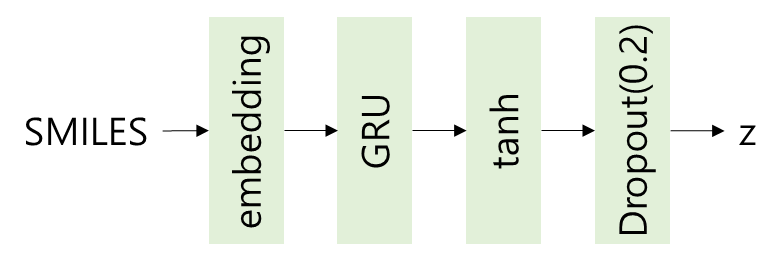

Embedding : 일종의 컴퓨터용 단어 사전.

sequence를 모두 정수로 인코딩. 정수 벡터를 dense vector(embedding bector)로 mapping. 이는 NN 학습과 동일한 과정으로 학습.

torch.nn.Embedding(num_embedding, embedding_dim)
* num_embedding : 임베딩한 단어의 개수 (단어 집합의 크기(n_char))
* embedding_dim : 사용자가 직접 정해주는 hyper parameter. 각 embedding vector 크기(n_hidden)

+) nn.GRU에는 자동으로 tanh가 포함되어 있음.

In [ ]:
class Model1(nn.Module):
    def __init__(self, n_char, n_hidden, n_rnn_layer = 1, dropout_prob = 0.2):
        """
        SMILES Encoder를 정의하는 부분.
        n_char : character 개수
        n_hidden : embedding된 이후 데이터 크기         # Hyper parameter
        n_rnn_layer : rnn layer 개수
        dropout_prob : dropout layer의 확률
        """
        super().__init__()

        self.n_char = n_char
        self.n_hidden = n_hidden
        self.n_rnn_layer = n_rnn_layer
        self.dropout_prob = dropout_prob

        """
        self.sos = nn.Parameter(torch.ones(1, 1, n_hidden))     # Start Of Sequence(SOS) 토큰
        self.sos.requires_grad = False
        """

        self.embedding = nn.Embedding(n_char, n_hidden)
        self.gru = nn.GRU(input_size = n_hidden, hidden_size = n_hidden, num_layers = n_rnn_layer, batch_first = True)
        self.drop = nn.Dropout(p = dropout_prob)

        # self.loss_fn = nn.CrossEntropyLoss(reduction="mean")

    def forward(self, x, length):
        """
        x (torch.Tensor): [B, L], B : batch size, L : 문자열 길이

        1. self.embedding을 이용하여 x를 hidden dimension으로 embed.
            x[B L] -> h[B L F]
        2. embed 된 데이터는 self.gru를 통과
            h[B L F] -> enc[B L F] -> z[B F]
        3. 이후, dropout 진행
            enc[B L F] -> d[B L F]
        4. 최종적으로 latent vector z 반환
            d[B L F] -> z[B F]
        """
        B = x.shape[0] # batch size
        L = x.shape[1] # 문자열 길이

        # 1. Embedding x[B L] -> h[B L F]
        h = self.embedding(x) # [B L F]

        # 2. Encoder h[B L F] -> enc[B L F]
        enc, _ = self.gru(h) # [B L F]

        # 3. enc[B L F] -> d[B L F]
        d = self.drop(enc)

        # 4. d[B L F] -> z[B L*F]
        # 이 단계에서 마지막 dimension의 가장 끝 정보만 latent vector로 이용할 수도 있고
        # L*F 길이의 벡터를 linear layer를 통과시켜 차원을 축소시켜 latent vector로 이용할 수도 있다.
        z = d.contiguous().view(B, L*self.n_hidden)

        return z

## 2-2. Model2 : NMR spectra+ 분자식(condition) -> z

* 입력 크기는 1300. (ppm 0.01~13.00까지. $(ppm)\times100-1=(index)$)
* NMR+분자식을 DNN, CNN에 통과시킨 후, 각각의 결과와 분자식을 concat하여 DNN을 통과
* CNN 세부 정보
    * in_channels = 1
    * out_channels : hyper parameter 설정. 대략 10~20 정도. multiplicity를 이해하길 기대
    * kernel_size : hyper parameter 설정. 49로 설정 계획중. 갈라질 때 ppm의 범위는 대략 0.5 정도.
    * stride = 1
    * padding = 24 ($(kernel size - 1)/2$)
    * 나머지는 default값 이용.
    * 이러면 input vector : [batch_size, 1, 1300], outvector : [batch_size, out_channels, 1300]
* DNN 세부 정보
    *

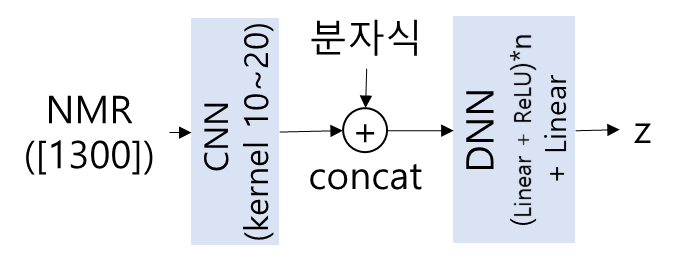

In [ ]:
class Model2(nn.Module):
    def __init__(self, hid_dim_2, n_hidden, in_channels = 1, out_channels = 15, kernel_size = 49, stride = 1, n_linear = 4, L = 120):
        """
        NMR spectra Encoder를 정의하는 부분
        in_channels : CNN의 input channel 개수. 스펙트럼 하나만 쓰기 때문에 1
        out_channels : Kernel 개수. 10~20 정도로 설정, multiplicity에 대응.
        kernel_size : 갈라짐 ppm의 범위가 대략 0.5정도이므로 49.
        stride : stride 개수. 기본값 1
        n_linear : DNN에서 linear layer개수
        hid_dim_2 : DNN에서 hidden dimension                                      # Hyper parameter
        n_hidden : DNN의 out_dim. 이는 Model1의 n_hidden과 같아야 함.           # Hyper parameter
        L : 문자열 길이. (x : [B, L])
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = int((kernel_size-1)/2)
        self.n_linear = n_linear
        self.in_dim = int(((1300-self.kernel_size+2*self.padding+1)/self.stride)*self.out_channels + 10)    # 디폴트 값인 경우, 1300*15 + 10
        self.hid_dim = hid_dim_2
        self.out_dim = L * n_hidden  # 이는 Model1에서 설정한 n_hidden과 같아야 함.

        self.cnn = nn.Conv1d(in_channels = self.in_channels, out_channels = self.out_channels, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding)

        layers = [nn.Linear(self.in_dim, self.hid_dim), nn.ReLU()]
        for _ in range(self.n_linear - 2):
            layers.append(nn.Linear(self.hid_dim, self.hid_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hid_dim, self.out_dim))

        self.dnn = nn.Sequential(*layers)

    def forward(self, spectra, mf):
        """
        spectra : 1300 길이의 torch.Tensor
        mf : 10 길이의 torch.Tensor

        1. 스펙트럼 정보를 CNN에 통과.
            [B, 1300] -> [B, 1, 1300] -> [B, kernel, 1300]
        2. CNN을 통과한 벡터들을 모두 concat.
            [B, kernel, 1300] -> [B, kernel*1300]
        3. 이와 분자식 정보를 concat
            [B, kernel*1300] + [B, 10] -> [B, kernel*1300 + 10]
        4. 이를 DNN에 통과시켜 latent vector를 얻음.
            [B, kernel*1300 + 10] -> [B, out_dim]
        """
        B = spectra.shape[0] # batch size

        # 1. CNN 통과
        spectra = spectra.float()
        spectra_ch1 = spectra.view(spectra.shape[0], 1, spectra.shape[1])
        c = self.cnn(spectra_ch1)

        # 2. CNN 통과한 kernel 개수의 벡터들을 모두 concat.
        c_concat = c.view(B, -1)

        # 3. 이와 분자식 정보를 concat
        cmf = torch.cat((c_concat, mf), dim=1)

        # 4. 이를 DNN에 통과시켜 z.
        z = self.dnn(cmf)

        return z

## 2-3. Model3 : z+ 분자식(condition) -> SMILES    (NMR-TS의 SMILES 학습 모델 참조)

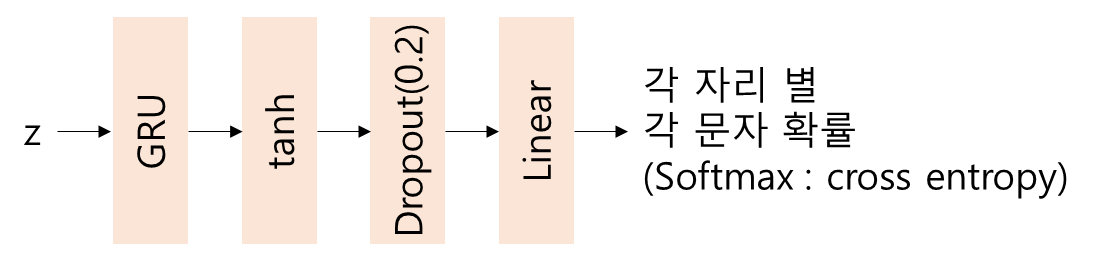

In [ ]:
class Model3(nn.Module):
    def __init__(self, n_char, n_hidden, hid_dim_3, n_rnn_layer = 1, dropout_prob = 0.2, L = 120):
        """
        SMILES Decoder를 정의하는 부분.
        n_char : character 개수
        n_hidden : embedding된 이후 데이터 크기         # Hyper parameter
        hid_dim_3 : linear layer의 hidden dimension     # Hyper parameter. 수업 예제에서는
        n_rnn_layer : rnn layer 개수
        dropout_prob : dropout layer의 확률
        """
        super().__init__()

        self.n_char = n_char
        self.n_hidden = n_hidden
        self.hid_dim = hid_dim_3
        self.n_rnn_layer = n_rnn_layer
        self.dropout_prob = dropout_prob
        self.L = L

        """
        self.sos = nn.Parameter(torch.ones(1, 1, n_hidden))
        self.sos.requires_grad = False
        """

        self.gru = nn.GRU(input_size = self.n_hidden, hidden_size = self.hid_dim, num_layers = self.n_rnn_layer, batch_first = True)
        self.drop = nn.Dropout(p = self.dropout_prob)
        self.fc_layer = nn.Linear(self.hid_dim, self.n_char)

        # self.loss_fn = nn.CrossEntropyLoss(reduction="mean")

    def forward(self, z):
        """
        1. z를 GRU에 통과
            z(정의한 크기에 따라 다름) -> [B, L, hid_dim]
        2.
        """
        B = z.shape[0] # batch size

        # 0. [B, L*F] -> [B, L, F]
        # 이는 latent vector 차원 처리에 따라 달라질 수 있음.
        z = z.view(B, self.L, self.n_hidden)

        # 1. GRU    [B, L, F] -> [B, L, hid_dim]
        dec, _ = self.gru(z)

        # 2. Dropout
        d = self.drop(dec)

        # 3. Predict the probability of character d[B L hid_dim] -> dec_final[B L N_CHAR]
        dec_final = self.fc_layer(d) # [B L N_CHAR]

        # losses = torch.stack([self.loss_fn(dec_final[i, :length[i], :], x[i, :length[i]]) / length[i] for i in range(B)], dim=0) # length due to <SOS>

        return dec_final

# 3. Hyperparameter Settings

In [ ]:
# 각 학습 step 별 Epoch
EPOCH_0 = 50
EPOCH_1 = 50
EPOCH_2 = 50

In [ ]:
# Learning Rate
LR_0 = 5e-6
LR_1 = 5e-6
LR_2 = 5e-6

# weight decay
# weight_decay = 0.01

In [ ]:
# model parameter
N_HIDDEN = 256
N_RNN_LAYER = 1
HID_DIM_2 = 5000
HID_DIM_3 = 256

BATCH_SIZE = 16
L = 120

In [ ]:
# train, validation, test ratio
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 1 - train_ratio - valid_ratio

# 4. Build the Dataset

In [ ]:
# Data dierection
SMILES_DIR = "./org_SMILES_120_canonical_100000.txt"
nmr_smi_list_txt = './nmr_smi_list_120.txt'
nmr_spectra_list_npy = './spectra_list_120.npy'

## 4-1. SMILES dataset

In [ ]:
# SMILES 리스트로부터 smi_list를 얻는 과정 정의 필요
with open(SMILES_DIR, 'r') as f:
    smi_list = [l.strip() for l in f.readlines()]

smi_dataset = MolDataset(smi_list)

# AutoEncoder 학습에 사용할 데이터는 test 불필요.
train_smi_dataset, valid_smi_dataset, _ = random_splitter(smi_dataset, train_ratio+valid_ratio, test_ratio, 0)

N_CHAR = smi_dataset._get_num_char()

In [ ]:
print(N_CHAR)
print(len(train_smi_dataset), len(valid_smi_dataset))

## 4-2. NMR dataset

In [ ]:
nmr_smi_list = []
with open(nmr_smi_list_txt, 'r') as file:
    for line in file:
        nmr_smi_list.append(line.strip())

nmr_spectra_numpy_list = np.load(nmr_spectra_list_npy, allow_pickle=True)
nmr_spectra_tensor_list = [torch.from_numpy(arr) for arr in nmr_spectra_numpy_list]

In [ ]:
nmr_dataset = MolNMRDataset(nmr_smi_list, nmr_spectra_tensor_list)

train_nmr_dataset, valid_nmr_dataset, test_nmr_dataset = random_splitter(nmr_dataset, train_ratio, valid_ratio, test_ratio)

In [ ]:
N_CHAR = nmr_dataset._get_num_char()
print(N_CHAR)
print(len(train_nmr_dataset), len(valid_nmr_dataset), len(test_nmr_dataset))

# 5. Build the DataLoader

In [ ]:
train_smi_dataloader = DataLoader(train_smi_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_smi_dataloader = DataLoader(valid_smi_dataset, batch_size=BATCH_SIZE, shuffle=False)
tr_smi_N = len(train_smi_dataset)
va_smi_N = len(valid_smi_dataset)

print(tr_smi_N, va_smi_N)

In [ ]:
train_nmr_dataloader = DataLoader(train_nmr_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_nmr_dataloader = DataLoader(valid_nmr_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_nmr_dataloader  = DataLoader(test_nmr_dataset,  batch_size=BATCH_SIZE, shuffle=False)
tr_nmr_N = len(train_nmr_dataset)
va_nmr_N = len(valid_nmr_dataset)
te_nmr_N = len(test_nmr_dataset)

print(tr_nmr_N, va_nmr_N, te_nmr_N)

# 6. Set Model and Optimizer

## 6-1. Model 정의

In [ ]:
# model1, 2, 3 정의. 위에서 정의한 변수 및 적절한 하이퍼 파라미터 포함.
model1 = Model1(n_char = N_CHAR, n_hidden = N_HIDDEN, n_rnn_layer = N_RNN_LAYER).to(device)
model2 = Model2(hid_dim_2 = HID_DIM_2, n_hidden = N_HIDDEN).to(device)
model3 = Model3(n_char = N_CHAR, n_hidden = N_HIDDEN, hid_dim_3 = HID_DIM_3, n_rnn_layer = N_RNN_LAYER).to(device)

## 6-2 (optional) Model 확인

In [ ]:
print("model 1 information")
print(model1)
# print(torch.summary(model1, input, device="cpu"))     # input 에 모델 input값 넣어주어야 함.
print("--------------------------------------------------------------------------------")
print("model 2 information")
print(model2)
# print(torch.summary(model2, input, device="cpu"))     # input 에 모델 input값 넣어주어야 함.
print("--------------------------------------------------------------------------------")
print("model 3 information")
print(model3)
# print(torch.summary(model1, input, device="cpu"))     # input 에 모델 input값 넣어주어야 함.

## 6-3 Optimizer 정의

In [ ]:
# optimizer 정의. (GPT : 초기에는 Adam을 사용해보고, 성능이 나아지지 않는 경우에는 SGD와 같은 간단한 최적화 알고리즘을 시도하는 것이 일반적인 접근 방식)
# 3가지 학습 과정 각각에 대해 optimizer가 정의 되어야 함.
# 테스트 이후 overfitting이나 oscillation 발생시, weight decay나 scheduler 이용.
optimizer_0 = optim.Adam(list(model1.parameters()) + list(model2.parameters()) + list(model3.parameters()),lr=LR_0)
optimizer_1 = optim.Adam(list(model1.parameters()) + list(model3.parameters()),lr=LR_1)
optimizer_2 = optim.Adam(list(model2.parameters()),lr=LR_2)

## 6-4. loss function 정의

In [ ]:
mse_loss = nn.MSELoss()
cre_loss = nn.CrossEntropyLoss(reduction="mean")

# 7. Train

학습 과정은 크게 3가지 단계로 나누어 하고자 함.

## 7-0. NMR 데이터 : SMILES + NMR spectra + 분자식

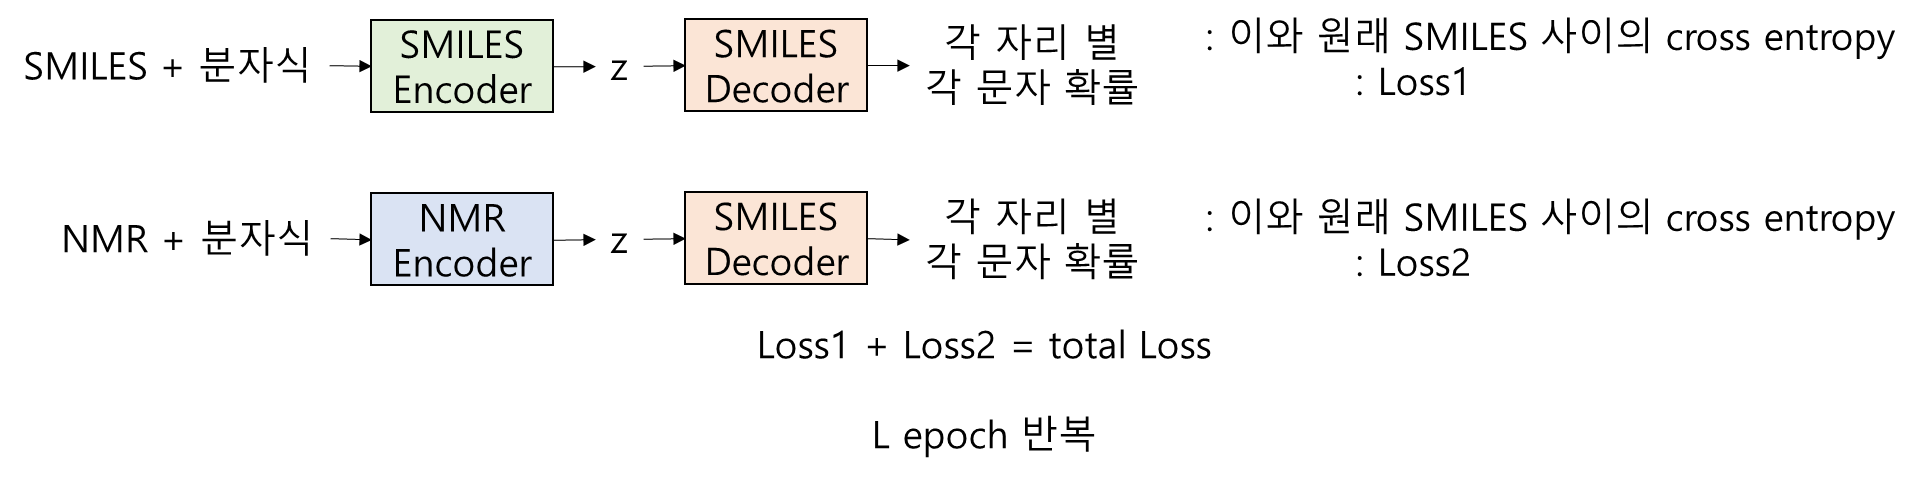

In [ ]:
def train_0(current_time,
            device = device,
            model1 = model1,
            model2 = model2,
            model3 = model3,
            train_dataloader = train_nmr_dataloader,
            valid_dataloader = valid_nmr_dataloader,
            tr_N = tr_nmr_N,
            va_N = va_nmr_N,
            optimizer = optimizer_0,
            loss_fn = cre_loss,
            NUM_EPOCH = EPOCH_0,
            BATCH_SIZE = BATCH_SIZE):
    model1.to(device)
    model2.to(device)
    model3.to(device)

    # 저장 위치 정의
    save_dir = f"./save/{current_time.strftime('%Y-%m-%d_%H-%M')}_train_0/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    # train
    train_loss_history, valid_loss_history = [], []
    best_loss = 1e6     # 임의의 큰 값
    best_model1_state_dict = model1.state_dict()
    best_model2_state_dict = model2.state_dict()
    best_model3_state_dict = model3.state_dict()
    for i in range(1, NUM_EPOCH + 1):
        # Train
        model1.train()
        model2.train()
        model3.train()
        train_batch_losses = []
        for batch_idx, batch in tqdm(enumerate(train_dataloader), total=tr_N // BATCH_SIZE):
            x_batch = batch["input"].long().to(device)
            l_batch = batch["length"].long().to(device)
            s_batch = batch["spectra"].to(device)
            m_batch = batch["mf"].long().to(device)

            z_1 = model1(x_batch, l_batch)
            dec_final_1 = model3(z_1)
            losses_1 = torch.stack([loss_fn(dec_final_1[i, :l_batch[i], :], x_batch[i, :l_batch[i]]) / l_batch[i] for i in range(len(x_batch))], dim=0)
            loss_1 = losses_1.sum()

            z_2 = model2(s_batch, m_batch)
            dec_final_2 = model3(z_2)
            losses_2 = torch.stack([loss_fn(dec_final_2[i, :l_batch[i], :], x_batch[i, :l_batch[i]]) / l_batch[i] for i in range(len(x_batch))], dim=0)
            loss_2 = losses_2.sum()

            loss = loss_1 + loss_2

            train_batch_losses.append(loss.data.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model1.eval()
        model2.eval()
        model3.eval()
        with torch.no_grad():
            valid_batch_losses = []
            for batch_idx, batch in tqdm(enumerate(valid_dataloader), total=va_N // BATCH_SIZE):
                x_batch = batch["input"].long().to(device)
                l_batch = batch["length"].long().to(device)
                s_batch = batch["spectra"].to(device)
                m_batch = batch["mf"].long().to(device)

                z_1 = model1(x_batch, l_batch)
                dec_final_1 = model3(z_1)
                losses_1 = torch.stack([loss_fn(dec_final_1[i, :l_batch[i], :], x_batch[i, :l_batch[i]]) / l_batch[i] for i in range(len(x_batch))], dim=0)
                loss_1 = losses_1.sum()

                z_2 = model2(s_batch, m_batch)
                dec_final_2 = model3(z_2)
                losses_2 = torch.stack([loss_fn(dec_final_2[i, :l_batch[i], :], x_batch[i, :l_batch[i]]) / l_batch[i] for i in range(len(x_batch))], dim=0)
                loss_2 = losses_2.sum()

                loss = loss_1 + loss_2

                valid_batch_losses.append(loss.data.cpu().numpy())

        # 해당 Epoch의 결과를 저장
        train_avg_loss = np.mean(np.array(train_batch_losses))
        valid_avg_loss = np.mean(np.array(valid_batch_losses))
        train_loss_history.append(train_avg_loss)
        valid_loss_history.append(valid_avg_loss)

        if valid_avg_loss < best_loss:
            best_epoch = i
            best_loss = valid_avg_loss
            torch.save(model1.state_dict(), os.path.join(save_dir, f"model1.pth"))
            torch.save(model2.state_dict(), os.path.join(save_dir, f"model2.pth"))
            torch.save(model3.state_dict(), os.path.join(save_dir, f"model3.pth"))
            best_model1_state_dict = model1.state_dict()
            best_model2_state_dict = model2.state_dict()
            best_model3_state_dict = model3.state_dict()

        print(f"\t{i}th EPOCH --- TRAIN LOSS: {train_avg_loss:.4f} || VALIDATION LOSS: {valid_avg_loss:.4f} || BEST EPOCH: {best_epoch}", flush=True)

    tlh_dir = os.path.join(save_dir, f"train_0_loss_history.txt")
    vlh_dir = os.path.join(save_dir, f"valid_0_loss_history.txt")
    with open(tlh_dir, 'w') as file:
        for item in train_loss_history:
            file.write(str(item) + '\n')
    with open(vlh_dir, 'w') as file:
        for item in valid_loss_history:
            file.write(str(item) + '\n')

    return train_loss_history, valid_loss_history, best_model1_state_dict, best_model2_state_dict, best_model3_state_dict

## 7-1. SMILES(+분자식) 데이터 학습

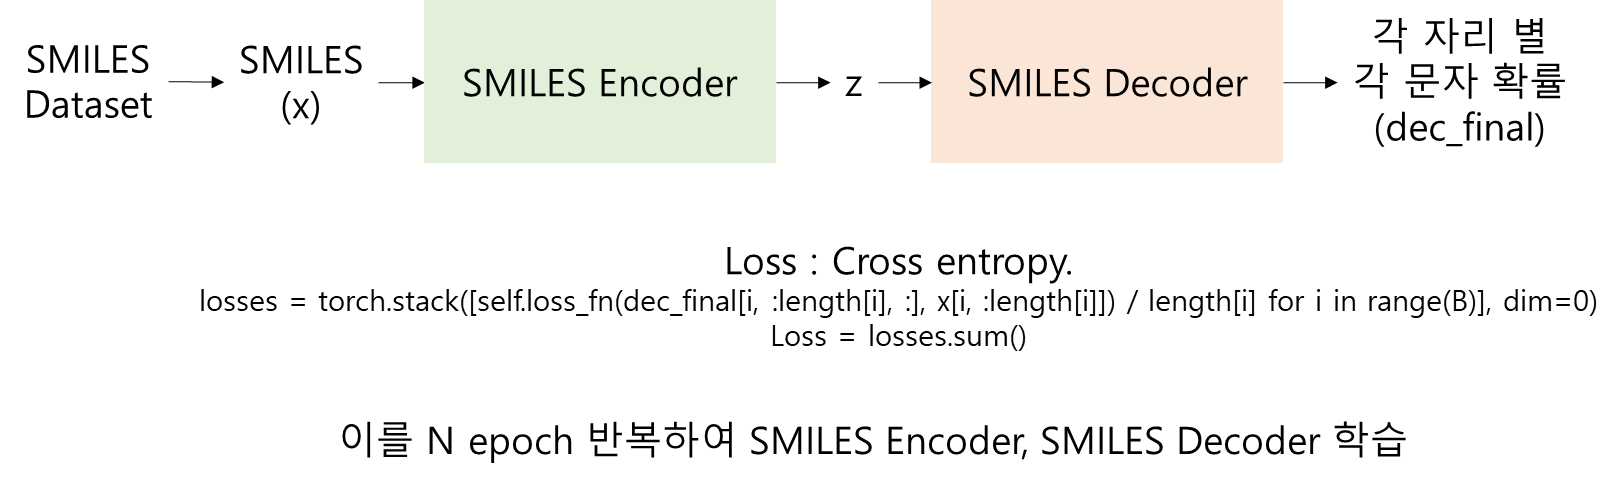

In [ ]:
def train_1(current_time,
            model1_state_dict = False,
            model3_state_dict = False,
            device = device,
            model1 = model1,
            model3 = model3,
            train_dataloader = train_smi_dataloader,
            valid_dataloader = valid_smi_dataloader,
            tr_N = tr_smi_N,
            va_N = va_smi_N,
            optimizer = optimizer_1,
            loss_fn = cre_loss,
            NUM_EPOCH = EPOCH_1,
            BATCH_SIZE = BATCH_SIZE):
    # model1 : SMILES Encoder, model3 : SMILES Decoder
    model1.to(device)
    model3.to(device)

    if model1_state_dict and model3_state_dict:
        print("train_1에서 model1, 3의 파라미터를 받았습니다.")
        model1.load_state_dict(model1_state_dict)
        model3.load_state_dict(model3_state_dict)

    # 저장 위치 정의
    save_dir = f"./save/{current_time.strftime('%Y-%m-%d_%H-%M')}_train_1/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    # train
    train_loss_history, valid_loss_history = [], []
    best_loss = 1e6     # 임의의 큰 값
    best_model1_state_dict = model1.state_dict()
    best_model3_state_dict = model3.state_dict()
    for i in range(1, NUM_EPOCH + 1):
        # Train
        model1.train()
        model3.train()
        train_batch_losses = []
        for batch_idx, batch in tqdm(enumerate(train_dataloader), total=tr_N // BATCH_SIZE):
            x_batch = batch["input"].long().to(device)
            l_batch = batch["length"].long().to(device)

            z = model1(x_batch, l_batch)
            dec_final = model3(z)

            losses = torch.stack([loss_fn(dec_final[i, :l_batch[i], :], x_batch[i, :l_batch[i]]) / l_batch[i] for i in range(len(x_batch))], dim=0)
            loss = losses.sum()

            train_batch_losses.append(loss.data.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model1.eval()
        model3.eval()
        with torch.no_grad():
            valid_batch_losses = []
            for batch_idx, batch in tqdm(enumerate(valid_dataloader), total=va_N // BATCH_SIZE):
                x_batch = batch["input"].long().to(device)
                l_batch = batch["length"].long().to(device)

                z = model1(x_batch, l_batch)
                dec_final = model3(z)

                losses = torch.stack([loss_fn(dec_final[i, :l_batch[i], :], x_batch[i, :l_batch[i]]) / l_batch[i] for i in range(len(x_batch))], dim=0)
                loss = losses.sum()

                valid_batch_losses.append(loss.data.cpu().numpy())

        # 해당 Epoch의 결과를 저장
        train_avg_loss = np.mean(np.array(train_batch_losses))
        valid_avg_loss = np.mean(np.array(valid_batch_losses))
        train_loss_history.append(train_avg_loss)
        valid_loss_history.append(valid_avg_loss)

        if valid_avg_loss < best_loss:
            best_epoch = i
            best_loss = valid_avg_loss
            torch.save(model1.state_dict(), os.path.join(save_dir, f"model1.pth"))
            torch.save(model3.state_dict(), os.path.join(save_dir, f"model3.pth"))
            best_model1_state_dict = model1.state_dict()
            best_model3_state_dict = model3.state_dict()

        print(f"\t{i}th EPOCH --- TRAIN LOSS: {train_avg_loss:.4f} || VALIDATION LOSS: {valid_avg_loss:.4f} || BEST EPOCH: {best_epoch}", flush=True)

    tlh_dir = os.path.join(save_dir, f"train_1_loss_history.txt")
    vlh_dir = os.path.join(save_dir, f"valid_1_loss_history.txt")
    with open(tlh_dir, 'w') as file:
        for item in train_loss_history:
            file.write(str(item) + '\n')
    with open(vlh_dir, 'w') as file:
        for item in valid_loss_history:
            file.write(str(item) + '\n')

    return train_loss_history, valid_loss_history, best_model1_state_dict, best_model3_state_dict

## 7-2. NMR -> Latent vector z 학습

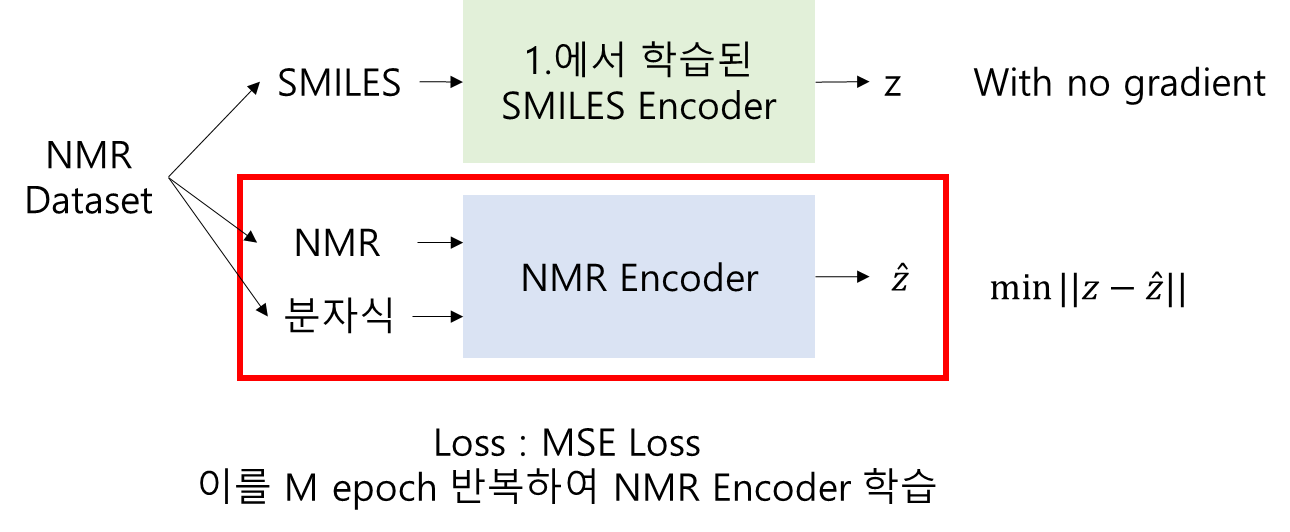

In [ ]:
def train_2(current_time,
            model1_state_dict,
            model2_state_dict = False,
            device = device,
            model1 = model1,
            model2 = model2,
            train_dataloader = train_nmr_dataloader,
            valid_dataloader = valid_nmr_dataloader,
            tr_N = tr_nmr_N,
            va_N = va_nmr_N,
            optimizer = optimizer_2,
            loss_fn = mse_loss,
            NUM_EPOCH = EPOCH_2,
            BATCH_SIZE = BATCH_SIZE):
    # model1의 state dictionary는 입력 해 주어야 함.
    # model1 : SMILES Encoder, model2 : NMR Encoder
    model1.to(device)
    model2.to(device)

    if model2_state_dict:
        print("model2의 파라미터를 받았습니다.")
        model2.load_state_dict(model2_state_dict)

    # 저장 위치 정의
    save_dir = f"./save/{current_time.strftime('%Y-%m-%d_%H-%M')}_train_2/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    # model1 을 evaluation mode로 설정하고, 기존에 학습된 파라미터를 불러옴.
    model1.eval()
    model1.load_state_dict(model1_state_dict)

    # train
    train_loss_history, valid_loss_history = [], []
    best_loss = 1e6     # 임의의 큰 값
    best_model2_state_dict = model2.state_dict()
    for i in range(1, NUM_EPOCH + 1):
        # Train
        model2.train()
        train_batch_losses = []
        for batch_idx, batch in tqdm(enumerate(train_dataloader), total = tr_N // BATCH_SIZE):
            x_batch = batch["input"].long().to(device)
            l_batch = batch["length"].long().to(device)
            s_batch = batch["spectra"].to(device)
            m_batch = batch["mf"].long().to(device)

            with torch.no_grad():
                z_1 = model1(x_batch, l_batch)
            z_2 = model2(s_batch, m_batch)

            loss = loss_fn(z_2, z_1)

            train_batch_losses.append(loss.data.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        model2.eval()
        with torch.no_grad():
            valid_batch_losses = []
            for batch_idx, batch in tqdm(enumerate(valid_dataloader), total=va_N // BATCH_SIZE):
                x_batch = batch["input"].long().to(device)
                l_batch = batch["length"].long().to(device)
                s_batch = batch["spectra"].long().to(device)
                m_batch = batch["mf"].long().to(device)

                z_1 = model1(x_batch, l_batch)
                z_2 = model2(s_batch, m_batch)

                loss = loss_fn(z_2, z_1)

                valid_batch_losses.append(loss.data.cpu().numpy())

        # 해당 Epoch의 결과를 저장
        train_avg_loss = np.mean(np.array(train_batch_losses))
        valid_avg_loss = np.mean(np.array(valid_batch_losses))
        train_loss_history.append(train_avg_loss)
        valid_loss_history.append(valid_avg_loss)

        if valid_avg_loss < best_loss:
            best_epoch = i
            best_loss = valid_avg_loss
            torch.save(model2.state_dict(), os.path.join(save_dir, f"model2.pth"))
            best_model2_state_dict = model2.state_dict()

        print(f"\t{i}th EPOCH --- TRAIN LOSS: {train_avg_loss:.4f} || VALIDATION LOSS: {valid_avg_loss:.4f} || BEST EPOCH: {best_epoch}", flush=True)

    tlh_dir = os.path.join(save_dir, f"train_2_loss_history.txt")
    vlh_dir = os.path.join(save_dir, f"valid_2_loss_history.txt")
    with open(tlh_dir, 'w') as file:
        for item in train_loss_history:
            file.write(str(item) + '\n')
    with open(vlh_dir, 'w') as file:
        for item in valid_loss_history:
            file.write(str(item) + '\n')

    return train_loss_history, valid_loss_history, best_model2_state_dict

# 8. 모델 학습 및 테스트

## 8-0. smi decoder 정의

In [ ]:
i_to_c = {v:k for k, v in c_to_i.items()}

In [ ]:
def decode_smi(x):
    """
    인코딩된 x는 길이 L의 정수(long) 배열.
    이를 인코딩때 사용한 배열의 역으로 다시 문자로 바꾸어 주어야 함.
    """
    while len(x) > 0 and x[-1] == 0:
        x = x[:-1]
    chlist = [i_to_c[int(i)] for i in x]
    smi = ''.join(chlist)
    return smi

## 8-1. Test 코드 정의

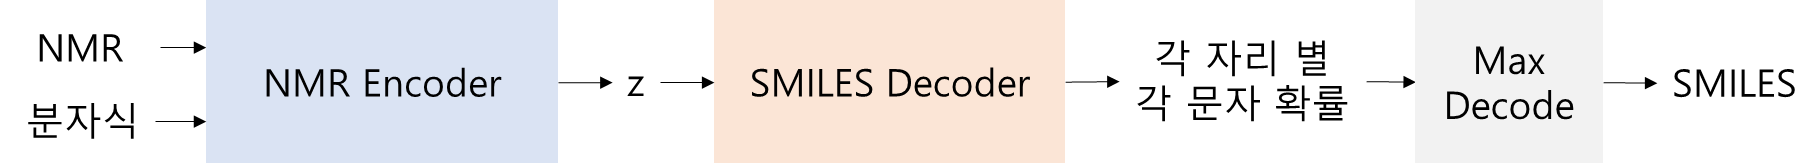

In [ ]:
def test_model(model2_state_dict,
               model3_state_dict,
               device = device,
               model2 = model2,
               model3 = model3,
               test_dataloader = test_nmr_dataloader,
               te_N = te_nmr_N,
               loss_fn = cre_loss,
               BATCH_SIZE = BATCH_SIZE):
    model2.to(device)
    model3.to(device)
    model2.load_state_dict(model2_state_dict)
    model3.load_state_dict(model3_state_dict)
    model2.eval()
    model3.eval()

    test_loss_list = []
    test_smi = []
    test_nmr = []
    test_mf = []
    test_out_smi = []

    with torch.no_grad():

        for batch_idx, batch in tqdm(enumerate(test_dataloader), total=te_N // BATCH_SIZE):
            x_batch = batch["input"].long().to(device)
            l_batch = batch["length"].long().to(device)
            s_batch = batch["spectra"].to(device)
            m_batch = batch["mf"].long().to(device)

            z = model2(s_batch, m_batch)
            dec_final = model3(z)

            losses = torch.stack([loss_fn(dec_final[i, :l_batch[i], :], x_batch[i, :l_batch[i]]) / l_batch[i] for i in range(len(x_batch))], dim=0)
            loss = losses.sum()
            test_loss_list.append(loss.data.cpu())

            x_batch = x_batch.cpu().tolist()
            s_batch = s_batch.cpu()
            m_batch = m_batch.cpu()
            dec_final = dec_final.cpu()

            for i in range(len(x_batch)):
                smi = decode_smi(x_batch[i])
                test_smi.append(smi)
                test_nmr.append(s_batch[i])
                test_mf.append(m_batch[i])

                out_smi_list = []
                lntensor = dec_final[i]
                for j in range(len(lntensor)):
                    i_prob = lntensor[j]
                    max_i = torch.argmax(i_prob)
                    out_smi_list.append(max_i)
                out_smi = decode_smi(out_smi_list)
                test_out_smi.append(out_smi)

    avg_loss = float(sum(test_loss_list) / len(test_loss_list))

    return avg_loss, test_out_smi, test_smi, test_nmr, test_mf

## 8-2. 모델 학습

In [ ]:
"""
# train 1, 2

current_time = datetime.now()

train_1_loss_history, valid_1_loss_history, best_model1_state_dict, best_model3_state_dict = train_1(current_time=current_time)
train_2_loss_history, valid_2_loss_history, best_model2_state_dict = train_2(current_time=current_time, model1_state_dict=best_model1_state_dict)
"""

In [ ]:
# train 0, 1, 2

current_time = datetime.now()

train_0_loss_history, valid_0_loss_history, model1_state_dict, model2_state_dict, model3_state_dict = train_0(current_time = current_time)
train_1_loss_history, valid_1_loss_history, best_model1_state_dict, best_model3_state_dict = train_1(current_time=current_time, model1_state_dict = model1_state_dict, model3_state_dict = model3_state_dict)
train_2_loss_history, valid_2_loss_history, best_model2_state_dict = train_2(current_time=current_time, model1_state_dict=best_model1_state_dict, model2_state_dict = model2_state_dict)

### 8-2-1. 저장된 모델 파라미터 불러오기

In [ ]:
"""
best_model1_state_dict = torch.load('./save/folder name/model1.pth')
best_model2_state_dict = torch.load('./save/folder name/model1.pth')
best_model3_state_dict = torch.load('./save/folder name/model3.pth')
"""

## 8-3 학습 과정 loss plot

In [ ]:
# Train 0
print(min(train_0_loss_history), min(valid_0_loss_history), valid_0_loss_history.index(min(valid_0_loss_history))+1)

x_axis = np.arange(EPOCH_0)
fig, ax = plt.subplots()
ax.plot(x_axis, train_0_loss_history, label='train loss')
ax.plot(x_axis, valid_0_loss_history, label='validation loss')
ax.set_xlabel('Num epoch')
ax.set_ylabel('Loss')
ax.set_title('train 0 Loss History')
ax.legend()
fig.show()

In [ ]:
# Train 1
print(min(train_1_loss_history), min(valid_1_loss_history), valid_1_loss_history.index(min(valid_1_loss_history))+1)

x_axis = np.arange(EPOCH_1)
fig, ax = plt.subplots()
ax.plot(x_axis, train_1_loss_history, label='train loss')
ax.plot(x_axis, valid_1_loss_history, label='validation loss')
ax.set_xlabel('Num epoch')
ax.set_ylabel('Loss')
ax.set_title('train 1 Loss History')
ax.legend()
fig.show()

In [ ]:
# Train 2
print(min(train_2_loss_history), min(valid_2_loss_history), valid_2_loss_history.index(min(valid_2_loss_history))+1)

x_axis = np.arange(EPOCH_2)
fig, ax = plt.subplots()
ax.plot(x_axis, train_2_loss_history, label='train loss')
ax.plot(x_axis, valid_2_loss_history, label='validation loss')
ax.set_xlabel('Num epoch')
ax.set_ylabel('Loss')
ax.set_title('train 2 Loss History')
ax.legend()
fig.show()

## 8-4. NMR Test dataset으로 결과 확인

In [ ]:
final_test_loss, test_out_smi, test_smi, test_nmr, test_mf = test_model(model2_state_dict = best_model2_state_dict, model3_state_dict = best_model3_state_dict)
print("final test loss :", final_test_loss)

## 8-5 생성된 분자 세트 확인

### 8-5-1. valid molecule set

In [ ]:
valid_smi_list = []
for i, smi in enumerate(test_out_smi):
    if len(smi) == 0:
        continue
    elif 'X' in smi:
        continue
    try:
        mol = Chem.MolFromSmiles(smi)
        assert mol is not None
    except:
        continue
    valid_smi_list.append([i, smi])

In [ ]:
print("valid SMILES :",len(valid_smi_list))
print("valid SMILES ratio in test nmr dataset :", len(valid_smi_list) / len(test_out_smi))

### 8-5-2. valid한 분자를 정답 분자와 비교

In [ ]:
print("결과로 나온 valid한 물질 / 정답 물질")
tc_list = []
for i in range(len(valid_smi_list)):
    print("생성된 SMILES :", valid_smi_list[i][1])
    mol1 = Chem.MolFromSmiles(valid_smi_list[i][1])
    # img1 = Draw.MolToImage(mol1)
    # display(img1)
    print("정답 SMILES :", test_smi[valid_smi_list[i][0]])
    mol2 = Chem.MolFromSmiles(test_smi[valid_smi_list[i][0]])
    # img2 = Draw.MolToImage(mol2)
    # display(img2)

    fp1 = AllChem.GetMorganFingerprint(mol1, 2)
    fp2 = AllChem.GetMorganFingerprint(mol2, 2)
    tanimoto_coefficient = DataStructs.TanimotoSimilarity(fp1, fp2)
    tc_list.append(tanimoto_coefficient)
    print("tanimoto coefficient :", tanimoto_coefficient)
    print("---------------------------------------------------------")
print("tanimoto coefficient 평균 :", sum(tc_list) / len(tc_list))
print("tanimoto coefficient 최솟값 :", min(tc_list))
print("tanimoto coefficient 최댓값 :", max(tc_list))